In [1]:
!pip install nibabel

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import RandomAffine

warnings.filterwarnings('ignore')

In [3]:
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
            
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, out_channels//16, kernel_size=1),
            nn.ReLU(),
            nn.Conv3d(out_channels//16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x * self.se(x)
        x += self.shortcut(residual)
        return F.relu(x)

In [4]:
class ResNet14_3D(nn.Module):
    def __init__(self, num_classes=2, in_channels=1):
        super().__init__()
        self.in_channels = in_channels

        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, stride=1),
            self._make_layer(64, 128, stride=1),
            self._make_layer(128, 256, stride=2),
            self._make_layer(256, 512, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            BasicBlock3D(in_channels, out_channels, stride),
            BasicBlock3D(out_channels, out_channels, stride=1)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layers(x)
        x = self.avgpool(x)
        return torch.flatten(x, 1)


In [5]:
class MultiModalAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim // num_heads
        
        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.out = nn.Linear(dim, dim)
        
    def forward(self, mri_feat, dti_feat):
        B = mri_feat.size(0)
        q = self.W_q(mri_feat).view(B, self.num_heads, self.dim_head)
        k = self.W_k(dti_feat).view(B, self.num_heads, self.dim_head)
        v = self.W_v(dti_feat).view(B, self.num_heads, self.dim_head)
        
        attn_scores = torch.einsum('bhd,bhd->bh', q, k) / (self.dim_head ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        attended = torch.einsum('bh,bhd->bhd', attn_weights, v)
        attended = attended.reshape(B, -1)
        return self.out(attended)

In [6]:
class MADNet(nn.Module):
    def __init__(self, num_classes=3, use_mri=True, use_dti=True):
        super().__init__()
        self.use_mri = use_mri
        self.use_dti = use_dti
        
        # MRI branch
        if use_mri:
            self.mri_branch = nn.Sequential(
                ResNet14_3D(in_channels=1),
                nn.Dropout(0.4)
            )
        
        # DTI branch
        if use_dti:
            self.dti_branch = nn.Sequential(
                ResNet14_3D(in_channels=1),
                nn.Dropout(0.4)
            )

        self.demo_fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        if use_mri and use_dti:
            self.attention = MultiModalAttention(512, num_heads=8)
        
        combined_feat_size = 0
        if use_mri and use_dti:
            combined_feat_size = 512  
        elif use_mri or use_dti:
            combined_feat_size = 512 
        
        combined_feat_size += 128 

        self.classifier = nn.Sequential(
            nn.Linear(combined_feat_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, mri, dti, age, gender):
        features = []
        
        # Xử lý MRI nếu được kích hoạt
        if self.use_mri:
            mri_feat = self.mri_branch(mri)
            features.append(mri_feat)
        
        # Xử lý DTI nếu được kích hoạt
        if self.use_dti:
            dti_feat = self.dti_branch(dti)
            features.append(dti_feat)
        
        # Xử lý kết hợp nếu có cả 2 
        if self.use_mri and self.use_dti:
            fused = self.attention(mri_feat, dti_feat)
            combined_feat = fused
        elif self.use_mri:
            combined_feat = mri_feat
        elif self.use_dti:
            combined_feat = dti_feat
        
        demo = torch.cat([age.unsqueeze(1), gender.unsqueeze(1)], dim=1)
        demo_feat = self.demo_fc(demo)
        
        # Kết hợp đặc trưng ảnh và nhân khẩu học
        combined = torch.cat((combined_feat, demo_feat), dim=1)
        return self.classifier(combined)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        focal_loss = (1 - pt).clamp(min=1e-7)**self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()

In [8]:
class MedicalDataset(Dataset):
    def __init__(self, df, data_dir, target_shape=(182, 182, 16), is_train=False):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.target_shape = target_shape
        self.is_train = is_train
        self.default_shape = (182, 218, 182)  

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        mri_fp = os.path.join(self.data_dir, row['mri_link'], 'image.nii').replace('\\', '/') if pd.notna(row['mri_link']) else None
        dti_fp = os.path.join(self.data_dir, row['dti_link'], 'image.nii').replace('\\', '/') if pd.notna(row['dti_link']) else None

        def load_vol(path):
            if path and os.path.isfile(path):
                vol = nib.load(path).get_fdata().astype(np.float32)
                return (vol - vol.mean()) / (vol.std() + 1e-8)
            return np.zeros(self.default_shape, dtype=np.float32)

        mri_vol = load_vol(mri_fp)
        dti_vol = load_vol(dti_fp)

        def resize_vol(vol, shape):
            tz, ty, tx = shape
            z, y, x = vol.shape
            cz, cy, cx = min(z, tz), min(y, ty), min(x, tx)
            sz, sy, sx = (z-cz)//2, (y-cy)//2, (x-cx)//2
            dz, dy, dx = (tz-cz)//2, (ty-cy)//2, (tx-cx)//2
            out = np.zeros((tz, ty, tx), dtype=vol.dtype)
            out[dz:dz+cz, dy:dy+cy, dx:dx+cx] = vol[sz:sz+cz, sy:sy+cy, sx:sx+cx]
            return out

        mri_vol = resize_vol(mri_vol, self.target_shape)
        dti_vol = resize_vol(dti_vol, self.target_shape)

        if self.is_train:
            aug = RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
            mri_vol = aug(torch.from_numpy(mri_vol).unsqueeze(0)).squeeze().numpy()
            dti_vol = aug(torch.from_numpy(dti_vol).unsqueeze(0)).squeeze().numpy()

        mri_tensor = torch.from_numpy(mri_vol).unsqueeze(0)
        dti_tensor = torch.from_numpy(dti_vol).unsqueeze(0)

        age = torch.tensor(row['age_norm'], dtype=torch.float32)
        gender = torch.tensor(row['gender'], dtype=torch.float32)
        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'mri': mri_tensor,
            'dti': dti_tensor,
            'age': age,
            'gender': gender,
            'label': label
        }

In [9]:
def initialize_model():
    class_counts = [111, 41, 20]
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()
    sample_weights = class_weights[labels]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = MADNet(num_classes=3, use_mri=True, use_dti=False)
    model.apply(lambda m: nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
           if isinstance(m, (nn.Conv3d, nn.Linear)) else None)
    
    criterion = FocalLoss(alpha=class_weights.to(device), gamma=2)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.2)
    
    return model.to(device), criterion, optimizer, scheduler

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100):
    device = next(model.parameters()).device
    best_acc = 0.0
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    print(f"Starting training for {epochs} epochs on {device}")
    print("-" * 60)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        all_train_preds, all_train_labels = [], []
        
        train_pbar = tqdm(train_loader, desc=f'Train Epoch {epoch+1:3d}/{epochs}')
        for batch_idx, batch in enumerate(train_pbar):
            inputs = {
                'mri': batch['mri'].to(device, non_blocking=True),
                'dti': batch['dti'].to(device, non_blocking=True),
                'age': batch['age'].to(device, non_blocking=True),
                'gender': batch['gender'].to(device, non_blocking=True)
            }
            labels = batch['label'].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            current_acc = train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.4f}'
            })
        
        train_loss_avg = train_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Val   Epoch {epoch+1:3d}/{epochs}')
            for batch in val_pbar:
                inputs = {
                    'mri': batch['mri'].to(device, non_blocking=True),
                    'dti': batch['dti'].to(device, non_blocking=True),
                    'age': batch['age'].to(device, non_blocking=True),
                    'gender': batch['gender'].to(device, non_blocking=True)
                }
                labels = batch['label'].to(device, non_blocking=True)
                
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
                current_acc = val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        val_loss_avg = val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        
        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'history': history
            }, 'best_model.pth')
            print(f'✓ New best model saved! Val Acc: {best_acc:.4f}')
        
        print(f'Epoch {epoch+1:3d}/{epochs}: '
              f'Train Loss: {train_loss_avg:.4f} Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss_avg:.4f} Acc: {val_acc:.4f} | '
              f'LR: {current_lr:.2e}')
        
        if (epoch + 1) % 10 == 0:
            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
            print(f'    F1 Scores - Train: {train_f1:.4f}, Val: {val_f1:.4f}')
        
        print("-" * 60)
    
    print(f'\nTraining completed!')
    print(f'Best validation accuracy: {best_acc:.4f} at epoch {best_epoch}')
    
    return history

In [11]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].to(device)
            
            outputs = model(**inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

In [12]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda
Class counts: [241 241 241]
Class weights: tensor([0.0041, 0.0041, 0.0041], device='cuda:0')
Starting training...
Starting training for 70 epochs on cuda:0
------------------------------------------------------------


Val   Epoch   1/70: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it, Loss=0.6347, Acc=0.1818]


✓ New best model saved! Val Acc: 0.1818
Epoch   1/70: Train Loss: 1.2278 Acc: 0.3514 | Val Loss: 1.2971 Acc: 0.1818 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   2/70: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it, Loss=0.3089, Acc=0.1970]


✓ New best model saved! Val Acc: 0.1970
Epoch   2/70: Train Loss: 1.1382 Acc: 0.4125 | Val Loss: 1.5522 Acc: 0.1970 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   3/70: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it, Loss=0.0279, Acc=0.1970]


Epoch   3/70: Train Loss: 1.0803 Acc: 0.4653 | Val Loss: 2.7590 Acc: 0.1970 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   4/70: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, Loss=0.7233, Acc=0.2727]


✓ New best model saved! Val Acc: 0.2727
Epoch   4/70: Train Loss: 1.0682 Acc: 0.4833 | Val Loss: 1.4239 Acc: 0.2727 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   5/70: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it, Loss=2.2139, Acc=0.4495]


✓ New best model saved! Val Acc: 0.4495
Epoch   5/70: Train Loss: 1.0460 Acc: 0.5208 | Val Loss: 1.1161 Acc: 0.4495 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   6/70: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it, Loss=3.6417, Acc=0.4242]


Epoch   6/70: Train Loss: 1.0550 Acc: 0.5000 | Val Loss: 1.3619 Acc: 0.4242 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   7/70: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it, Loss=0.0341, Acc=0.2626]


Epoch   7/70: Train Loss: 0.9739 Acc: 0.5222 | Val Loss: 2.5411 Acc: 0.2626 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   8/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=0.8938, Acc=0.4141]


Epoch   8/70: Train Loss: 1.0058 Acc: 0.5125 | Val Loss: 1.0248 Acc: 0.4141 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch   9/70: 100%|██████████| 13/13 [00:16<00:00,  1.28s/it, Loss=0.7411, Acc=0.5202]


✓ New best model saved! Val Acc: 0.5202
Epoch   9/70: Train Loss: 0.9547 Acc: 0.5319 | Val Loss: 1.0061 Acc: 0.5202 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch  10/70: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it, Loss=2.2576, Acc=0.4798]


Epoch  10/70: Train Loss: 0.9446 Acc: 0.5694 | Val Loss: 1.0823 Acc: 0.4798 | LR: 1.00e-04
    F1 Scores - Train: 0.5715, Val: 0.4291
------------------------------------------------------------


Val   Epoch  11/70: 100%|██████████| 13/13 [00:25<00:00,  1.96s/it, Loss=1.7611, Acc=0.3636]


Epoch  11/70: Train Loss: 0.8934 Acc: 0.5681 | Val Loss: 1.2109 Acc: 0.3636 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch  12/70: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it, Loss=0.2487, Acc=0.1970]


Epoch  12/70: Train Loss: 0.9414 Acc: 0.5528 | Val Loss: 1.9380 Acc: 0.1970 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch  13/70: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it, Loss=1.3781, Acc=0.4646]


Epoch  13/70: Train Loss: 0.8834 Acc: 0.5611 | Val Loss: 1.0441 Acc: 0.4646 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch  14/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=1.0009, Acc=0.4545]


Epoch  14/70: Train Loss: 0.8661 Acc: 0.5792 | Val Loss: 1.0239 Acc: 0.4545 | LR: 1.00e-04
------------------------------------------------------------


Val   Epoch  15/70: 100%|██████████| 13/13 [00:16<00:00,  1.31s/it, Loss=2.4882, Acc=0.4495]


Epoch  15/70: Train Loss: 0.8667 Acc: 0.5722 | Val Loss: 1.0619 Acc: 0.4495 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  16/70: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it, Loss=2.4136, Acc=0.4495]


Epoch  16/70: Train Loss: 0.8440 Acc: 0.5875 | Val Loss: 1.0672 Acc: 0.4495 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  17/70: 100%|██████████| 13/13 [00:26<00:00,  2.04s/it, Loss=2.2224, Acc=0.4798]


Epoch  17/70: Train Loss: 0.8439 Acc: 0.5875 | Val Loss: 1.0529 Acc: 0.4798 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  18/70: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it, Loss=1.4305, Acc=0.4848]


Epoch  18/70: Train Loss: 0.7987 Acc: 0.6222 | Val Loss: 1.0264 Acc: 0.4848 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  19/70: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it, Loss=2.6513, Acc=0.4798]


Epoch  19/70: Train Loss: 0.8434 Acc: 0.5875 | Val Loss: 1.0990 Acc: 0.4798 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  20/70: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it, Loss=1.1578, Acc=0.4343]


Epoch  20/70: Train Loss: 0.7844 Acc: 0.6167 | Val Loss: 0.9877 Acc: 0.4343 | LR: 2.00e-05
    F1 Scores - Train: 0.6196, Val: 0.4292
------------------------------------------------------------


Val   Epoch  21/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.2688, Acc=0.5253]


✓ New best model saved! Val Acc: 0.5253
Epoch  21/70: Train Loss: 0.7837 Acc: 0.5972 | Val Loss: 1.0719 Acc: 0.5253 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  22/70: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, Loss=1.7556, Acc=0.4949]


Epoch  22/70: Train Loss: 0.7613 Acc: 0.6264 | Val Loss: 1.0294 Acc: 0.4949 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  23/70: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it, Loss=1.3896, Acc=0.5505]


✓ New best model saved! Val Acc: 0.5505
Epoch  23/70: Train Loss: 0.7950 Acc: 0.6028 | Val Loss: 1.0296 Acc: 0.5505 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  24/70: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it, Loss=3.1115, Acc=0.4747]


Epoch  24/70: Train Loss: 0.7890 Acc: 0.6028 | Val Loss: 1.1706 Acc: 0.4747 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  25/70: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it, Loss=2.8796, Acc=0.4545]


Epoch  25/70: Train Loss: 0.7408 Acc: 0.6236 | Val Loss: 1.1722 Acc: 0.4545 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  26/70: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it, Loss=1.9973, Acc=0.5707]


✓ New best model saved! Val Acc: 0.5707
Epoch  26/70: Train Loss: 0.7630 Acc: 0.6236 | Val Loss: 1.0611 Acc: 0.5707 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  27/70: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it, Loss=3.0618, Acc=0.4444]


Epoch  27/70: Train Loss: 0.7483 Acc: 0.6347 | Val Loss: 1.1862 Acc: 0.4444 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  28/70: 100%|██████████| 13/13 [00:25<00:00,  1.93s/it, Loss=1.7686, Acc=0.4141]


Epoch  28/70: Train Loss: 0.7345 Acc: 0.6417 | Val Loss: 1.1127 Acc: 0.4141 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  29/70: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it, Loss=1.5264, Acc=0.5202]


Epoch  29/70: Train Loss: 0.7501 Acc: 0.6319 | Val Loss: 1.0430 Acc: 0.5202 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  30/70: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it, Loss=2.5387, Acc=0.4495]


Epoch  30/70: Train Loss: 0.7386 Acc: 0.6375 | Val Loss: 1.1376 Acc: 0.4495 | LR: 2.00e-05
    F1 Scores - Train: 0.6417, Val: 0.4014
------------------------------------------------------------


Val   Epoch  31/70: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, Loss=2.0296, Acc=0.4091]


Epoch  31/70: Train Loss: 0.7108 Acc: 0.6514 | Val Loss: 1.1328 Acc: 0.4091 | LR: 2.00e-05
------------------------------------------------------------


Val   Epoch  32/70: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it, Loss=2.9861, Acc=0.4899]


Epoch  32/70: Train Loss: 0.7026 Acc: 0.6667 | Val Loss: 1.1711 Acc: 0.4899 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  33/70: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it, Loss=2.4519, Acc=0.4949]


Epoch  33/70: Train Loss: 0.6568 Acc: 0.6861 | Val Loss: 1.1114 Acc: 0.4949 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  34/70: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it, Loss=2.4415, Acc=0.5101]


Epoch  34/70: Train Loss: 0.7194 Acc: 0.6792 | Val Loss: 1.1295 Acc: 0.5101 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  35/70: 100%|██████████| 13/13 [00:25<00:00,  1.96s/it, Loss=2.0972, Acc=0.4495]


Epoch  35/70: Train Loss: 0.6640 Acc: 0.6667 | Val Loss: 1.1066 Acc: 0.4495 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  36/70: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it, Loss=2.5172, Acc=0.4596]


Epoch  36/70: Train Loss: 0.6905 Acc: 0.6833 | Val Loss: 1.1583 Acc: 0.4596 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  37/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.0566, Acc=0.4848]


Epoch  37/70: Train Loss: 0.6963 Acc: 0.6556 | Val Loss: 1.1118 Acc: 0.4848 | LR: 4.00e-06
------------------------------------------------------------


Val   Epoch  38/70: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it, Loss=2.4142, Acc=0.4899]


Epoch  38/70: Train Loss: 0.6233 Acc: 0.6972 | Val Loss: 1.1202 Acc: 0.4899 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  39/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.2451, Acc=0.4747]


Epoch  39/70: Train Loss: 0.6540 Acc: 0.6833 | Val Loss: 1.1148 Acc: 0.4747 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  40/70: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it, Loss=2.3614, Acc=0.4495]


Epoch  40/70: Train Loss: 0.6583 Acc: 0.6931 | Val Loss: 1.1256 Acc: 0.4495 | LR: 8.00e-07
    F1 Scores - Train: 0.6914, Val: 0.4371
------------------------------------------------------------


Val   Epoch  41/70: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, Loss=2.2362, Acc=0.4596]


Epoch  41/70: Train Loss: 0.6103 Acc: 0.7000 | Val Loss: 1.1078 Acc: 0.4596 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  42/70: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it, Loss=2.7713, Acc=0.4444]


Epoch  42/70: Train Loss: 0.6252 Acc: 0.7056 | Val Loss: 1.1676 Acc: 0.4444 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  43/70: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it, Loss=2.2977, Acc=0.4545]


Epoch  43/70: Train Loss: 0.5803 Acc: 0.7236 | Val Loss: 1.1186 Acc: 0.4545 | LR: 8.00e-07
------------------------------------------------------------


Val   Epoch  44/70: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it, Loss=2.5810, Acc=0.4848]


Epoch  44/70: Train Loss: 0.6782 Acc: 0.6736 | Val Loss: 1.1498 Acc: 0.4848 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  45/70: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it, Loss=2.2195, Acc=0.4545]


Epoch  45/70: Train Loss: 0.6463 Acc: 0.6750 | Val Loss: 1.1219 Acc: 0.4545 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  46/70: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it, Loss=1.7732, Acc=0.4949]


Epoch  46/70: Train Loss: 0.6793 Acc: 0.6736 | Val Loss: 1.1118 Acc: 0.4949 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  47/70: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it, Loss=2.1858, Acc=0.4949]


Epoch  47/70: Train Loss: 0.6355 Acc: 0.7056 | Val Loss: 1.1290 Acc: 0.4949 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  48/70: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, Loss=2.2429, Acc=0.4495]


Epoch  48/70: Train Loss: 0.6599 Acc: 0.6750 | Val Loss: 1.1220 Acc: 0.4495 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  49/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.2587, Acc=0.4899]


Epoch  49/70: Train Loss: 0.6948 Acc: 0.6542 | Val Loss: 1.1246 Acc: 0.4899 | LR: 1.60e-07
------------------------------------------------------------


Val   Epoch  50/70: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it, Loss=2.0185, Acc=0.4545]


Epoch  50/70: Train Loss: 0.6547 Acc: 0.6639 | Val Loss: 1.1061 Acc: 0.4545 | LR: 3.20e-08
    F1 Scores - Train: 0.6599, Val: 0.4504
------------------------------------------------------------


Val   Epoch  51/70: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it, Loss=2.0634, Acc=0.4495]


Epoch  51/70: Train Loss: 0.6704 Acc: 0.6694 | Val Loss: 1.1118 Acc: 0.4495 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  52/70: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it, Loss=2.4047, Acc=0.4495]


Epoch  52/70: Train Loss: 0.6565 Acc: 0.6792 | Val Loss: 1.1429 Acc: 0.4495 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  53/70: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it, Loss=2.3114, Acc=0.4798]


Epoch  53/70: Train Loss: 0.6826 Acc: 0.6625 | Val Loss: 1.1391 Acc: 0.4798 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  54/70: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it, Loss=2.1653, Acc=0.4697]


Epoch  54/70: Train Loss: 0.6278 Acc: 0.6944 | Val Loss: 1.1116 Acc: 0.4697 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  55/70: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it, Loss=1.9681, Acc=0.4697]


Epoch  55/70: Train Loss: 0.6534 Acc: 0.6889 | Val Loss: 1.1170 Acc: 0.4697 | LR: 3.20e-08
------------------------------------------------------------


Val   Epoch  56/70: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it, Loss=2.1702, Acc=0.4798]


Epoch  56/70: Train Loss: 0.6709 Acc: 0.6917 | Val Loss: 1.1204 Acc: 0.4798 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  57/70: 100%|██████████| 13/13 [00:25<00:00,  1.92s/it, Loss=2.3197, Acc=0.4646]


Epoch  57/70: Train Loss: 0.6143 Acc: 0.6931 | Val Loss: 1.1349 Acc: 0.4646 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  58/70: 100%|██████████| 13/13 [00:28<00:00,  2.15s/it, Loss=1.9445, Acc=0.4848]


Epoch  58/70: Train Loss: 0.6751 Acc: 0.6722 | Val Loss: 1.1100 Acc: 0.4848 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  59/70: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it, Loss=2.1070, Acc=0.4949]


Epoch  59/70: Train Loss: 0.6656 Acc: 0.6875 | Val Loss: 1.1157 Acc: 0.4949 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  60/70: 100%|██████████| 13/13 [00:13<00:00,  1.05s/it, Loss=2.0750, Acc=0.4848]


Epoch  60/70: Train Loss: 0.6900 Acc: 0.6528 | Val Loss: 1.1203 Acc: 0.4848 | LR: 6.40e-09
    F1 Scores - Train: 0.6470, Val: 0.4780
------------------------------------------------------------


Val   Epoch  61/70: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it, Loss=2.1487, Acc=0.4798]


Epoch  61/70: Train Loss: 0.6266 Acc: 0.7069 | Val Loss: 1.1192 Acc: 0.4798 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  62/70: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it, Loss=2.1580, Acc=0.4697]


Epoch  62/70: Train Loss: 0.6524 Acc: 0.6875 | Val Loss: 1.1200 Acc: 0.4697 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  63/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=2.1289, Acc=0.4697]


Epoch  63/70: Train Loss: 0.6381 Acc: 0.6861 | Val Loss: 1.1296 Acc: 0.4697 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  64/70: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it, Loss=2.1000, Acc=0.4697]


Epoch  64/70: Train Loss: 0.6234 Acc: 0.6958 | Val Loss: 1.1170 Acc: 0.4697 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  65/70: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it, Loss=2.1857, Acc=0.4949]


Epoch  65/70: Train Loss: 0.6244 Acc: 0.6944 | Val Loss: 1.1262 Acc: 0.4949 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  66/70: 100%|██████████| 13/13 [00:20<00:00,  1.55s/it, Loss=2.1042, Acc=0.4646]


Epoch  66/70: Train Loss: 0.6362 Acc: 0.6694 | Val Loss: 1.1159 Acc: 0.4646 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  67/70: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it, Loss=2.4111, Acc=0.4848]


Epoch  67/70: Train Loss: 0.6503 Acc: 0.6736 | Val Loss: 1.1377 Acc: 0.4848 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  68/70: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it, Loss=2.2557, Acc=0.4545]


Epoch  68/70: Train Loss: 0.5898 Acc: 0.6986 | Val Loss: 1.1269 Acc: 0.4545 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  69/70: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it, Loss=2.2114, Acc=0.4545]


Epoch  69/70: Train Loss: 0.6023 Acc: 0.7042 | Val Loss: 1.1233 Acc: 0.4545 | LR: 6.40e-09
------------------------------------------------------------


Val   Epoch  70/70: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it, Loss=1.9254, Acc=0.4697]


Epoch  70/70: Train Loss: 0.6624 Acc: 0.6972 | Val Loss: 1.1244 Acc: 0.4697 | LR: 6.40e-09
    F1 Scores - Train: 0.6930, Val: 0.4645
------------------------------------------------------------

Training completed!
Best validation accuracy: 0.5707 at epoch 26
Evaluating on test set...


Evaluating: 100%|██████████| 14/14 [00:46<00:00,  3.31s/it]



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.78      0.61        73
     Class 1       0.55      0.31      0.39        97
     Class 2       0.38      0.38      0.38        39

    accuracy                           0.49       209
   macro avg       0.48      0.49      0.46       209
weighted avg       0.50      0.49      0.47       209



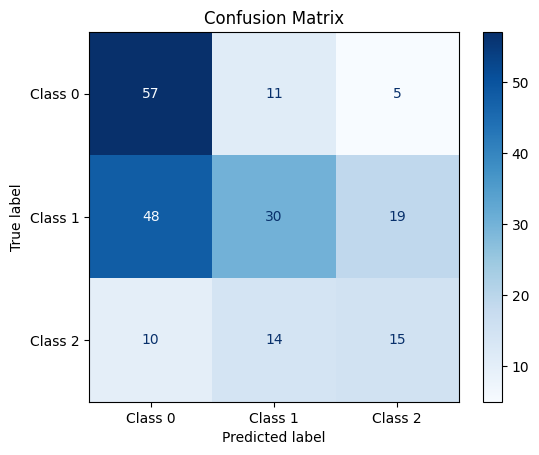

In [13]:
if __name__ == '__main__':
    data_dir = '/kaggle/input/medical'
    
    train_df = pd.read_csv('/kaggle/input/medical/data/train.csv')
    val_df = pd.read_csv('/kaggle/input/medical/data/val.csv')
    test_df = pd.read_csv('/kaggle/input/medical/data/test.csv')

    def check_path(df):
        for index, row in df.iterrows():
            mri_path = os.path.join(data_dir, row['mri_link'], 'image.nii') if pd.notna(row['mri_link']) else None
            dti_path = os.path.join(data_dir, row['dti_link'], 'image.nii') if pd.notna(row['dti_link']) else None
            
            if mri_path and not os.path.exists(mri_path):
                df.at[index, 'mri_link'] = None
            if dti_path and not os.path.exists(dti_path):
                df.at[index, 'dti_link'] = None
        return df

    train_df = check_path(train_df)
    val_df = check_path(val_df)
    test_df = check_path(test_df)

    def balance_classes(df):
        class_1 = df[df['diagnosis'] == 1].sample(min(241, len(df[df['diagnosis'] == 1])), random_state=42)
        class_2 = df[df['diagnosis'] == 2].sample(min(241, len(df[df['diagnosis'] == 2])), random_state=42)
        class_3 = df[df['diagnosis'] == 3]
        return pd.concat([class_1, class_2, class_3])
    
    train_df = balance_classes(train_df)
    
    scaler = StandardScaler()
    train_age = train_df['age_at_visit'].values.reshape(-1, 1)
    scaler.fit(train_age)
    
    for df in [train_df, val_df, test_df]:
        df['label'] = df['diagnosis'] - 1
        df['age_norm'] = scaler.transform(df['age_at_visit'].values.reshape(-1, 1)).flatten()
        df['gender'] = df['ptgender'] - 1

    train_dataset = MedicalDataset(train_df, data_dir, target_shape=(182, 182, 16), is_train=True)
    val_dataset = MedicalDataset(val_df, data_dir, target_shape=(182, 182, 16))
    test_dataset = MedicalDataset(test_df, data_dir, target_shape=(182, 182, 16))

    train_labels = train_df['label'].astype(int).values
    class_counts = np.bincount(train_labels)
    sample_weights = 1. / class_counts[train_labels]
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        sampler=WeightedRandomSampler(sample_weights, len(sample_weights)),
        num_workers=4,
        drop_last=True
    )
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = MADNet(num_classes=3, use_mri=True, use_dti=False).to(device)
    
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
    print(f"Class counts: {class_counts}")
    print(f"Class weights: {class_weights}")
    
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.2
    )

    print("Starting training...")
    history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        epochs=70
    )

    print("Evaluating on test set...")
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                              target_names=['Class 0', 'Class 1', 'Class 2']))
    
    class_names = ['Class 0', 'Class 1', 'Class 2']
    plot_confusion_matrix(test_labels, test_preds, class_names)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

In [15]:
def print_full_results(model, train_loader, val_loader, test_loader, history, device, class_names):
    print("\n" + "="*60)
    print("TỔNG HỢP KẾT QUẢ HUẤN LUYỆN")
    print("="*60)
    
    best_epoch = np.argmax(history['val_acc'])
    print(f"Epoch tốt nhất: {best_epoch+1}")
    print(f"Train Acc: {history['train_acc'][best_epoch]:.4f} | Val Acc: {history['val_acc'][best_epoch]:.4f}")
    print(f"Train Loss: {history['train_loss'][best_epoch]:.4f} | Val Loss: {history['val_loss'][best_epoch]:.4f}")
    
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP TRAIN")
    print("="*60)
    train_results = evaluate_set(model, train_loader, device, "Train", class_names)
    
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP VALIDATION")
    print("="*60)
    val_results = evaluate_set(model, val_loader, device, "Validation", class_names)
    
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP TEST")
    print("="*60)
    test_results = evaluate_set(model, test_loader, device, "Test", class_names)
    
    print("\n" + "="*60)
    print("TỔNG HỢP CUỐI CÙNG")
    print("="*60)
    print(f"{'Dataset':<12} | {'Accuracy':<8} | {'F1 Score':<8} | {'Precision':<8} | {'Recall':<8}")
    print("-"*60)
    print(f"{'Train':<12} | {train_results['accuracy']:.4f}    | {train_results['f1']:.4f}    | {train_results['precision']:.4f}    | {train_results['recall']:.4f}")
    print(f"{'Validation':<12} | {val_results['accuracy']:.4f}    | {val_results['f1']:.4f}    | {val_results['precision']:.4f}    | {val_results['recall']:.4f}")
    print(f"{'Test':<12} | {test_results['accuracy']:.4f}    | {test_results['f1']:.4f}    | {test_results['precision']:.4f}    | {test_results['recall']:.4f}")
    
    return {
        'train': train_results,
        'val': val_results,
        'test': test_results
    }

In [16]:
def evaluate_set(model, loader, device, set_name, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f'Evaluating {set_name} Set'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds)
    all_probs_np = np.array(all_probs)

    accuracy = accuracy_score(all_labels_np, all_preds_np)
    f1_macro = f1_score(all_labels_np, all_preds_np, average='macro')
    f1_weighted = f1_score(all_labels_np, all_preds_np, average='weighted')
    precision = precision_score(all_labels_np, all_preds_np, average='macro')
    recall = recall_score(all_labels_np, all_preds_np, average='macro')

    try:
        auc_macro = roc_auc_score(all_labels_np, all_probs_np, multi_class='ovo', average='macro')
    except ValueError:
        auc_macro = float('nan')

    print(f"\n{set_name} Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"AUC (Macro): {auc_macro:.4f}")

    print(f"\nClassification Report for {set_name} Set:")
    print(classification_report(all_labels_np, all_preds_np, target_names=class_names))

    print("Confusion Matrix:")
    cm = plot_confusion_matrix_only(
        all_labels_np,
        all_preds_np,
        classes=class_names,
        title=f'{set_name} Set Confusion Matrix'
    )

    return {
        'accuracy': accuracy,
        'f1': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'auc_macro': auc_macro,
        'predictions': all_preds_np,
        'labels': all_labels_np,
        'confusion_matrix': cm
    }


In [17]:
import seaborn as sns

def plot_confusion_matrix_only(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()
    plt.close()

    return cm



TỔNG HỢP KẾT QUẢ HUẤN LUYỆN
Epoch tốt nhất: 26
Train Acc: 0.6236 | Val Acc: 0.5707
Train Loss: 0.7630 | Val Loss: 1.0611

ĐÁNH GIÁ TRÊN TẬP TRAIN


Evaluating Train Set: 100%|██████████| 45/45 [01:33<00:00,  2.09s/it]



Train Accuracy: 0.7333
F1-Score (Macro): 0.7373
F1-Score (Weighted): 0.7328
Recall (Macro): 0.7375
Precision (Macro): 0.7380
AUC (Macro): 0.8886

Classification Report for Train Set:
              precision    recall  f1-score   support

      Normal       0.64      0.69      0.66       251
         MCI       0.64      0.60      0.62       241
   Alzheimer       0.93      0.93      0.93       228

    accuracy                           0.73       720
   macro avg       0.74      0.74      0.74       720
weighted avg       0.73      0.73      0.73       720

Confusion Matrix:


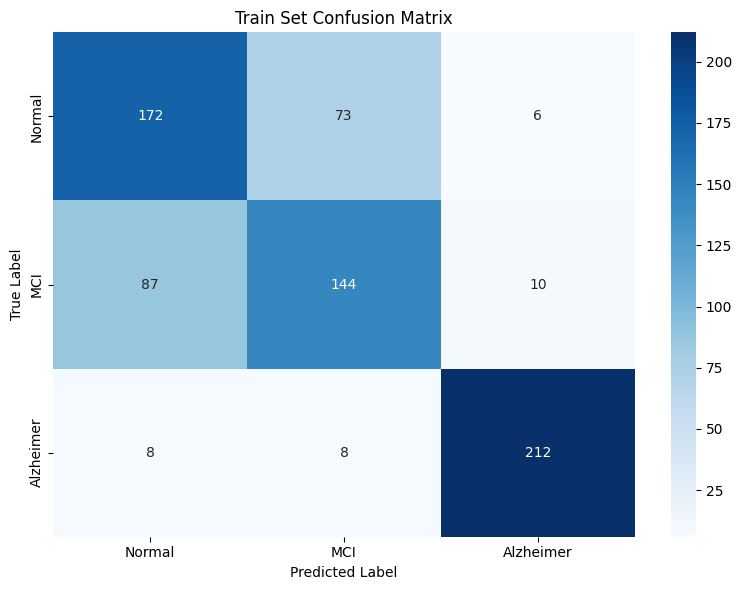


ĐÁNH GIÁ TRÊN TẬP VALIDATION


Evaluating Validation Set: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]



Validation Accuracy: 0.4697
F1-Score (Macro): 0.4359
F1-Score (Weighted): 0.4645
Recall (Macro): 0.4353
Precision (Macro): 0.4436
AUC (Macro): 0.6217

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Normal       0.48      0.58      0.53        79
         MCI       0.51      0.45      0.47        83
   Alzheimer       0.34      0.28      0.31        36

    accuracy                           0.47       198
   macro avg       0.44      0.44      0.44       198
weighted avg       0.47      0.47      0.46       198

Confusion Matrix:


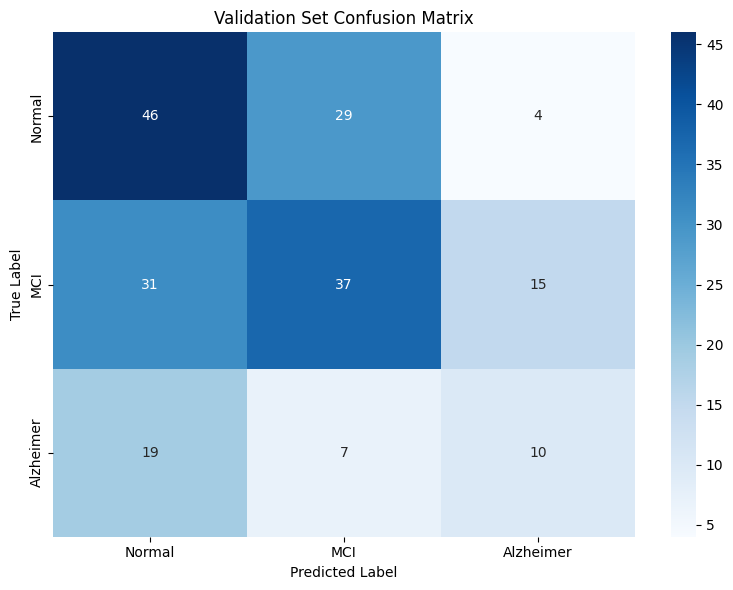


ĐÁNH GIÁ TRÊN TẬP TEST


Evaluating Test Set: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



Test Accuracy: 0.4880
F1-Score (Macro): 0.4619
F1-Score (Weighted): 0.4668
Recall (Macro): 0.4916
Precision (Macro): 0.4752
AUC (Macro): 0.7219

Classification Report for Test Set:
              precision    recall  f1-score   support

      Normal       0.50      0.78      0.61        73
         MCI       0.55      0.31      0.39        97
   Alzheimer       0.38      0.38      0.38        39

    accuracy                           0.49       209
   macro avg       0.48      0.49      0.46       209
weighted avg       0.50      0.49      0.47       209

Confusion Matrix:


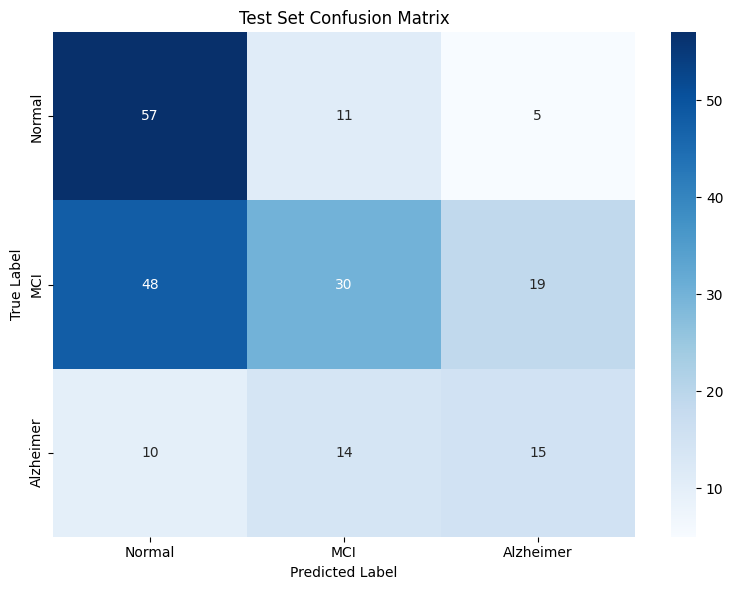


TỔNG HỢP CUỐI CÙNG
Dataset      | Accuracy | F1 Score | Precision | Recall  
------------------------------------------------------------
Train        | 0.7333    | 0.7373    | 0.7380    | 0.7375
Validation   | 0.4697    | 0.4359    | 0.4436    | 0.4353
Test         | 0.4880    | 0.4619    | 0.4752    | 0.4916


In [18]:
class_names = ['Normal', 'MCI', 'Alzheimer']  

final_results = print_full_results(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    history=history,
    device=device,
    class_names=class_names
)